In [ ]:
from importlib import reload

import numpy as np
from ioh import ProblemClass, get_problem

import FewShotCVRP.bo.bo_ei_hvea as bo_ei_hvea
import FewShotCVRP.utils.plots as myplots

reload(bo_ei_hvea)


f = get_problem(fid=22, instance=1, dimension=2, problem_class=ProblemClass.BBOB)

bo_iteration = 0

bo = bo_ei_hvea.BayesianOptimizerEIHVEA(
    f,
    f_batch=None,
    bounds=[(-5.0, 5.0), (-5.0, 5.0)],
    n_init=10,
    n_iter=20,
    sigma=0.001,
    kernel="rbf",
    kernel_isotropic=True,
    length_scale_bounds=(0.1, 10.0),
    c_factor_bounds=(1 / 2, 2.0),
    suggestions_per_step=10,  # 3 diverse local maxima of EI per iteration
    diversity_frac=0.1,  # 10% of average box size as min separation
    random_state=1,
)
result = bo.run()
gp = bo.get_gp()
print("Best x:", result["x_obs_best"], "Best y:", result["y_obs_best"])
print(
    "Recommended x:",
    result["x_rec_mean_global"],
    "Best y:",
    result["x_rec_mean_global"],
)
print("Kernel:", gp.kernel_)
print("\nARD report:")
bo.report_ard()

arrays = {
    "X_": bo.X_,
    "y_": bo.y_,
    "bounds": bo.bounds,
    "f_": np.array(
        [
            "import ioh; f = ioh.get_problem(fid=22, instance=1, dimension=2, problem_class=ioh.ProblemClass.BBOB)"
        ],
        dtype=object,
    ),
}
np.savez_compressed("kernel-pca-debug-data.npz", **arrays)


Running HillVallEA on the defined objective function
Selected 6 new points
Running HillVallEA on the defined objective function
Selected 10 new points
Running HillVallEA on the defined objective function
Selected 8 new points
Running HillVallEA on the defined objective function
Selected 10 new points
Running HillVallEA on the defined objective function
Selected 10 new points
Running HillVallEA on the defined objective function
Selected 10 new points
Running HillVallEA on the defined objective function
Selected 10 new points
Running HillVallEA on the defined objective function
Selected 10 new points
Running HillVallEA on the defined objective function
Selected 10 new points
Running HillVallEA on the defined objective function
Selected 10 new points
Running HillVallEA on the defined objective function
Selected 10 new points
Running HillVallEA on the defined objective function
Selected 10 new points
Running HillVallEA on the defined objective function
Selected 10 new points
Running HillVa

In [8]:
from collections import namedtuple

import numpy as np

arrays_file = np.load("kernel-pca-debug-data.npz", allow_pickle=True)
my_arrays = {k: arrays_file[k] for k in arrays_file.files}
print('Creating objective function f:', my_arrays['f_'][0])
exec(my_arrays['f_'][0])
DummyBO = namedtuple('DummyBO', ['X_', 'y_', 'bounds'])
bo = DummyBO(X_=my_arrays['X_'], y_=my_arrays['y_'], bounds=my_arrays['bounds'])

Creating objective function f: import ioh; f = ioh.get_problem(fid=22, instance=1, dimension=2, problem_class=ioh.ProblemClass.BBOB)


In [5]:
import FewShotCVRP.utils.plots as myplots

myplots.good_plt_config()

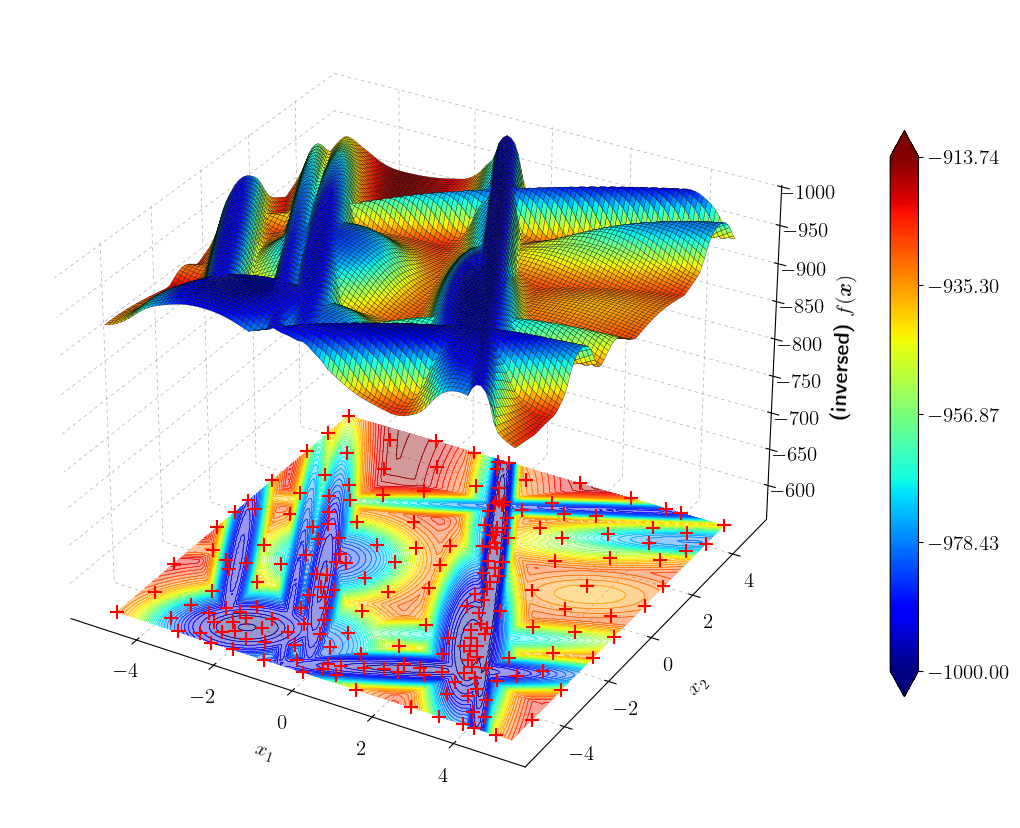

In [6]:
fig, ax = myplots.plot_3D_surface(
    (-5, 5),
    (-5, 5),
    f,
    bo.X_,
    is_axis_names=True,
    is_white_facecolor=True,
    is_colorbar=True,
    discretization=100,
    zfactor=2.0,
    is_inverse=True,
)

In [ ]:
import FewShotCVRP.bo.kpcabo as kpcabo
mapper = kpcabo.KernelPCAMapper(bounds=bo.bounds, eta=0.66, pad_frac=0.1, random_state=1)
mapper.fit(bo.X_, bo.y_)
Z = mapper.transform(bo.X_, bo.y_)

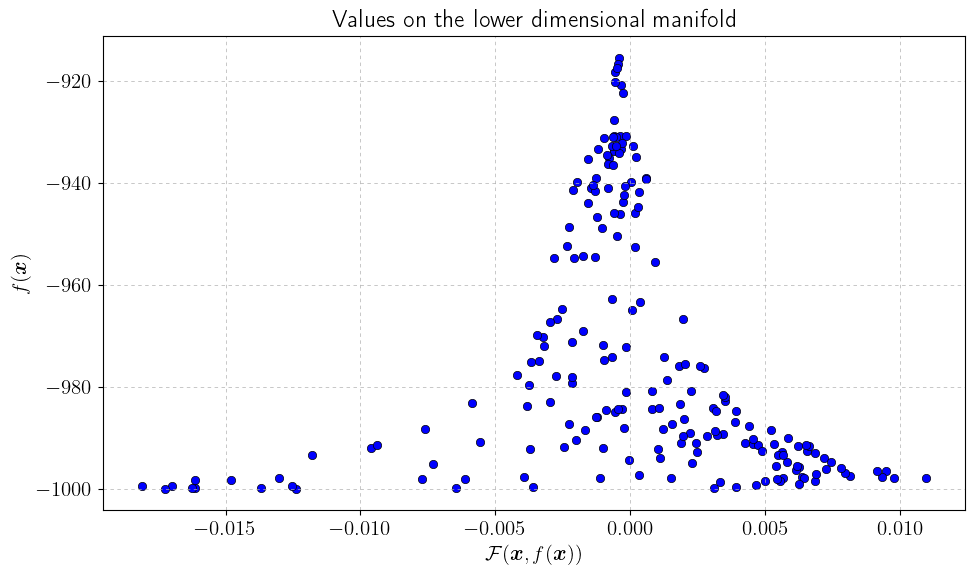

In [10]:
# Импортируем необходимые библиотеки
import matplotlib.pyplot as plt
import numpy as np

# Создаем примерные данные (можно заменить на ваши x и y)
# Если у вас уже есть готовые массивы x и y, пропустите этот шаг
x = Z[:, 0]  # 100 точек от 0 до 10
y = bo.y_  # Пример функции

# Создаем график
plt.figure(figsize=(10, 6))  # Размер фигуры в дюймах

# Строим линию
plt.scatter(x, y,  ec="k", lw=0.5, alpha=1, color="blue", linestyle="-", marker="o")

plt.title("Values on the lower dimensional manifold")

# Подписываем оси
plt.xlabel(r"$\mathcal{F}\!\br{\bm{x}, f(\bm{x})}$")
plt.ylabel(r"$f(\bm{x})$")

# Добавляем сетку
# plt.grid(True, linestyle='--', alpha=0.7)

# Добавляем легенду
# plt.legend(loc="best")

# Отображаем график
plt.tight_layout()  # Автоматическое расположение элементов
plt.show()

In [5]:
from scipy.optimize import minimize
from scipy.stats import norm
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF
from sklearn.gaussian_process.kernels import ConstantKernel as C
from sklearn.gaussian_process.kernels import Matern, WhiteKernel

kernel = C(1.0, (0.5, 10.0)) * RBF(
    length_scale=1.0,
    length_scale_bounds=(0.0001, 100.0),
) + WhiteKernel(
    noise_level=5.0**2,
    noise_level_bounds=(
        0.1**2,
        10.0**2,
    ),
)

gp = GaussianProcessRegressor(
    kernel=kernel,
    alpha=0.0,
    normalize_y=True,
    n_restarts_optimizer=5,
    random_state=1,
)
gp.fit(x[:, None], y)


GaussianProcessRegressor(alpha=0.0,
                         kernel=1**2 * RBF(length_scale=1) + WhiteKernel(noise_level=25),
                         n_restarts_optimizer=5, normalize_y=True,
                         random_state=1)

In [9]:
gp.kernel

1**2 * RBF(length_scale=1) + WhiteKernel(noise_level=25)

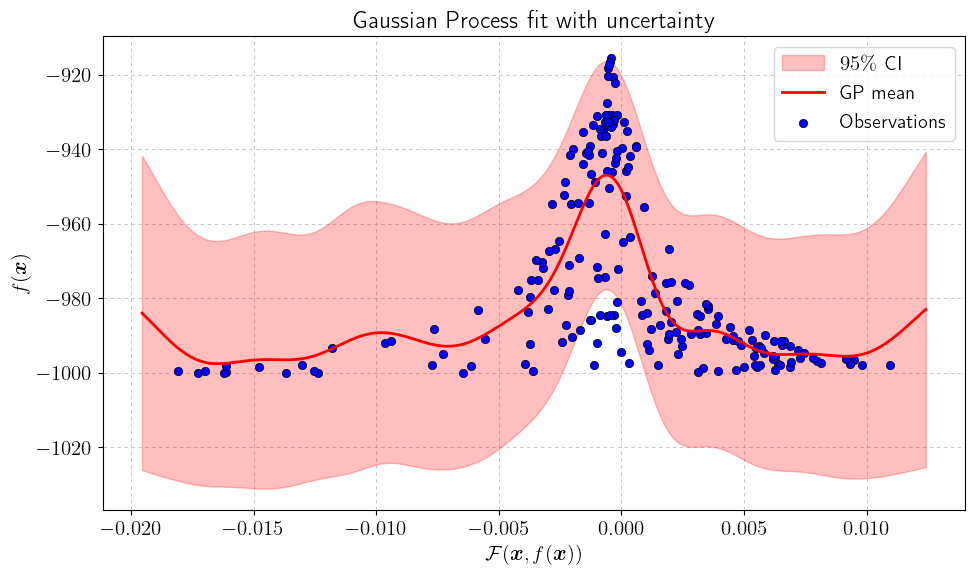

In [6]:
import numpy as np
import matplotlib.pyplot as plt

import numpy as np
import matplotlib.pyplot as plt

def plot_gp_1d(gp, x, y, n_grid=500, n_samples=0, ax=None):
    """
    Plot a 1D GaussianProcessRegressor fit with uncertainty.
    Assumes gp is already fitted on (x[:, None], y).
    """
    x = np.asarray(x).ravel()
    y = np.asarray(y).ravel()

    # Build a dense grid with a small margin around data range
    ptp = np.ptp(x) if x.size > 1 else 1.0   # <-- fixed here
    margin = 0.05 * ptp
    x_min, x_max = x.min() - margin, x.max() + margin
    X_plot = np.linspace(x_min, x_max, n_grid).reshape(-1, 1)

    # Predict posterior mean and std on the grid
    mu, std = gp.predict(X_plot, return_std=True)

    # Prepare axis
    created_ax = False
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 6))
        created_ax = True

    # 95% confidence band
    ax.fill_between(
        X_plot.ravel(),
        mu - 1.96 * std,
        mu + 1.96 * std,
        alpha=0.25,
        label=r"$95\%$ CI",
        color="red",
        zorder=2
    )

    # Posterior mean
    ax.plot(X_plot.ravel(), mu, lw=2, label="GP mean", color="red", zorder=3)

    # Optional: posterior samples
    if n_samples > 0:
        mu_s, cov_s = gp.predict(X_plot, return_cov=True)
        rng = np.random.default_rng()
        samples = rng.multivariate_normal(mu_s, cov_s, size=n_samples)
        for s in samples:
            ax.plot(X_plot.ravel(), s, lw=1, alpha=0.7)

    # Training data
    ax.scatter(x, y, ec="k", lw=0.5, alpha=1, label="Observations", color="blue", zorder=2.5)

    ax.set_xlabel(r"$\mathcal{F}\!\br{\bm{x}, f(\bm{x})}$")
    ax.set_ylabel(r"$f(\bm{x})$")
    ax.set_title("Gaussian Process fit with uncertainty")
    ax.legend(loc="best")
    # ax.grid(True, alpha=0.2)

    if created_ax:
        plt.tight_layout()
        plt.show()

# --- usage example (gp is already fitted on (x[:, None], y)) ---
plot_gp_1d(gp, x, y, n_grid=600, n_samples=0)


In [ ]:
import FewShotCVRP.bo.bo_pure as bo_pure

def EI(gp_, xi, y_, X) -> np.ndarray:
    X = bo_pure._to_2d(np.asarray(X, dtype=float))
    mu, sigma = gp_.predict(X, return_std=True)
    sigma = np.maximum(sigma, 1e-12)

    y_best = np.min(y_)
    improv = y_best - mu - xi

    Z = improv / sigma
    ei = improv * norm.cdf(Z) + sigma * norm.pdf(Z)
    ei = np.where(sigma <= 1e-12, 0.0, ei)
    return ei

bo_ei = lambda x_: EI(gp, 0.01, y, x_)[0]

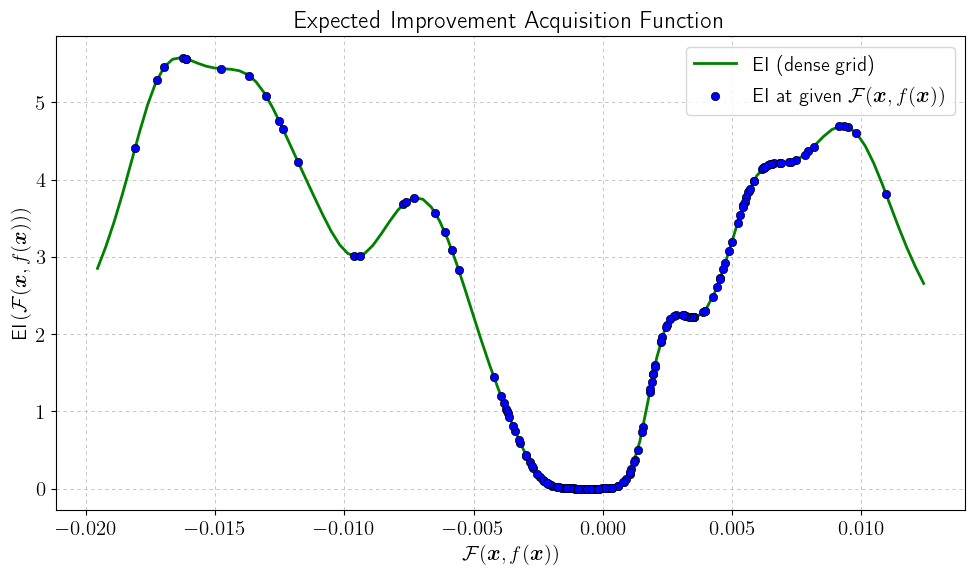

In [8]:
import numpy as np
import matplotlib.pyplot as plt


def plot_ei(bo_ei, x, n_grid=500, ax=None):
    """
    Plot acquisition function bo_ei(x) at training points and on a dense grid.

    Parameters
    ----------
    bo_ei : callable
        Acquisition function, accepts 1D numpy array or list of scalars.
    x : (n,) array_like
        Input points where GP is trained or evaluated.
    n_grid : int
        Number of equally spaced points in the plot.
    ax : matplotlib.axes.Axes, optional
        Axis to draw on. If None, a new figure is created.
    """
    x = np.asarray(x).ravel()
    ptp = np.ptp(x) if x.size > 1 else 1.0
    margin = 0.05 * ptp
    x_min, x_max = x.min() - margin, x.max() + margin

    # Dense grid spanning the same range
    X_grid = np.linspace(x_min, x_max, n_grid)

    # Evaluate EI at grid and at given x
    y_grid = np.array([bo_ei([X_grid_i]) for X_grid_i in X_grid])
    y_x = np.array([bo_ei([x_i]) for x_i in x])

    # Prepare axis
    created_ax = False
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 6))
        created_ax = True

    # Plot dense curve
    ax.plot(X_grid, y_grid, lw=2, label="EI (dense grid)", color="green")

    # Plot values at x
    ax.scatter(x, y_x, ec="k", lw=0.5, alpha=1, zorder=5, label=r"EI at given $\mathcal{F}\!\br{\bm{x}, f(\bm{x})}$", color="blue")

    ax.set_xlabel(r"$\mathcal{F}\!\br{\bm{x}, f(\bm{x})}$")
    ax.set_ylabel(r"$\text{EI}\br{\mathcal{F}\!\br{\bm{x}, f(\bm{x})}}$")
    ax.set_title("Expected Improvement Acquisition Function")
    ax.legend(loc="best")

    if created_ax:
        plt.tight_layout()
        # plt.show()
    return ax


ax_ei = plot_ei(bo_ei, x, n_grid=100)

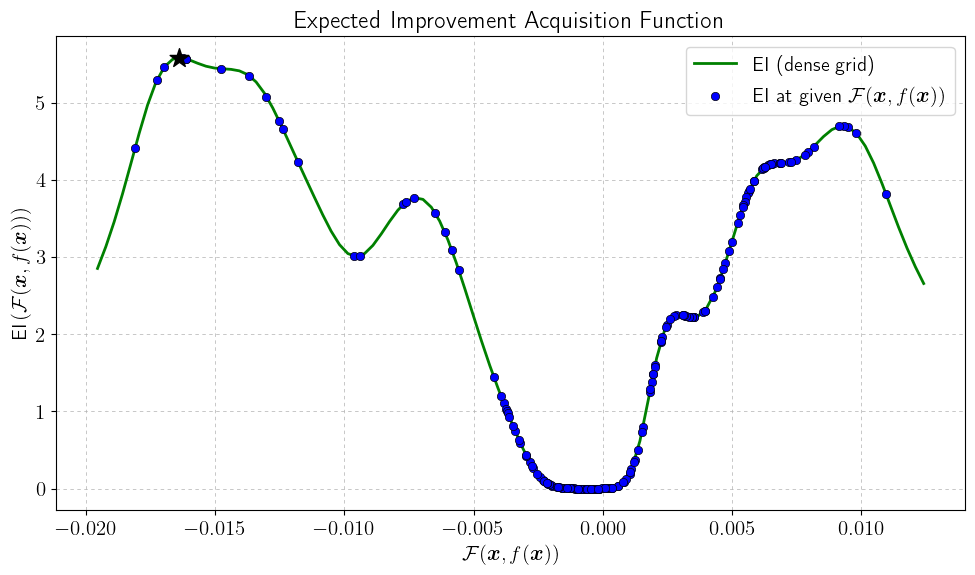

In [9]:
res = minimize(
    lambda x: -bo_ei(x),
    x0=[-0.015],
    method="L-BFGS-B",
    jac=False,
    bounds=[(-1.0, 1.0)],
)
ax_ei = plot_ei(bo_ei, x, n_grid=100)
ax_ei.scatter(res.x, [bo_ei(res.x)], s=200, marker="*", color="black", zorder=5)

In [10]:
z = res.x
z_obj_approx = gp.predict(bo_pure._to_2d(z), return_std=False)


In [ ]:
zz = [-0.005]
zz_obj_approx = gp.predict(bo_pure._to_2d(zz), return_std=False)
print(zz_obj_approx)

[-989.31372887]


[-987.52353065]
2.2276233213238004e-16
2.0384938036315642e-16
CMAEvolutionStrategyResult(xbest=array([0.78926772, 0.2107323 ]), fbest=2.0384938036315642e-16, evals_best=434, evaluations=450, iterations=75, xfavorite=array([0.78927653, 0.21072344]), stds=array([3.44294068e-05, 3.44515823e-05]), stop={'tolfun': 1e-10, 'tolfunhist': 1e-10})


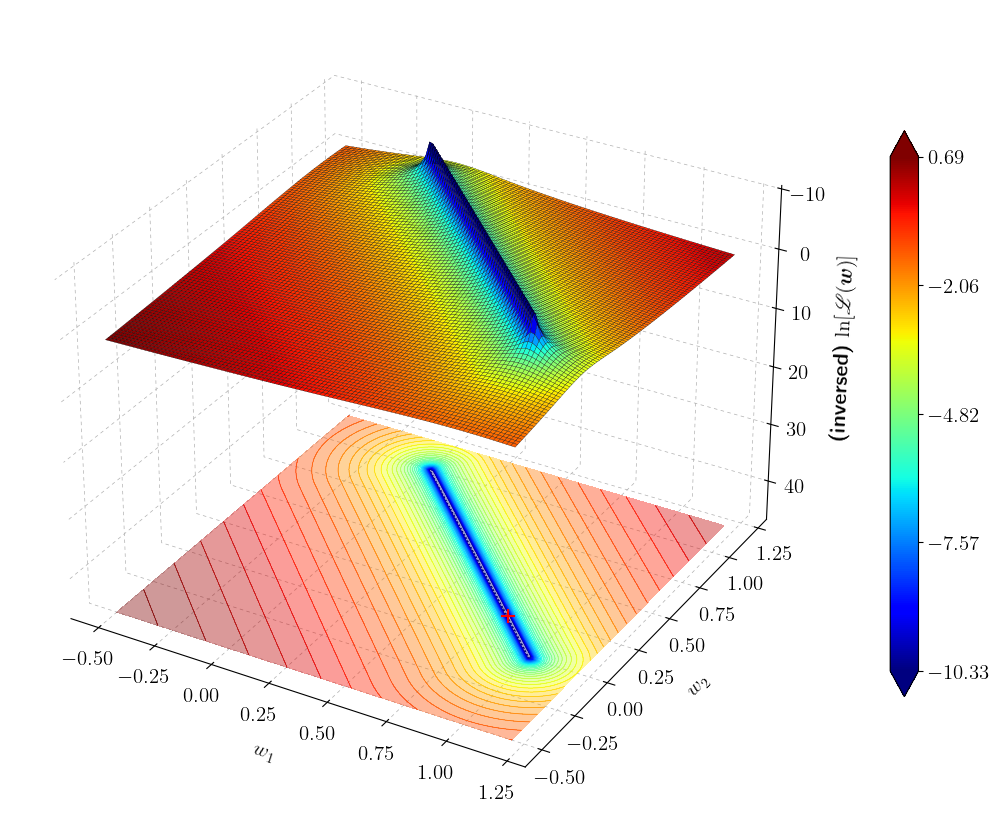

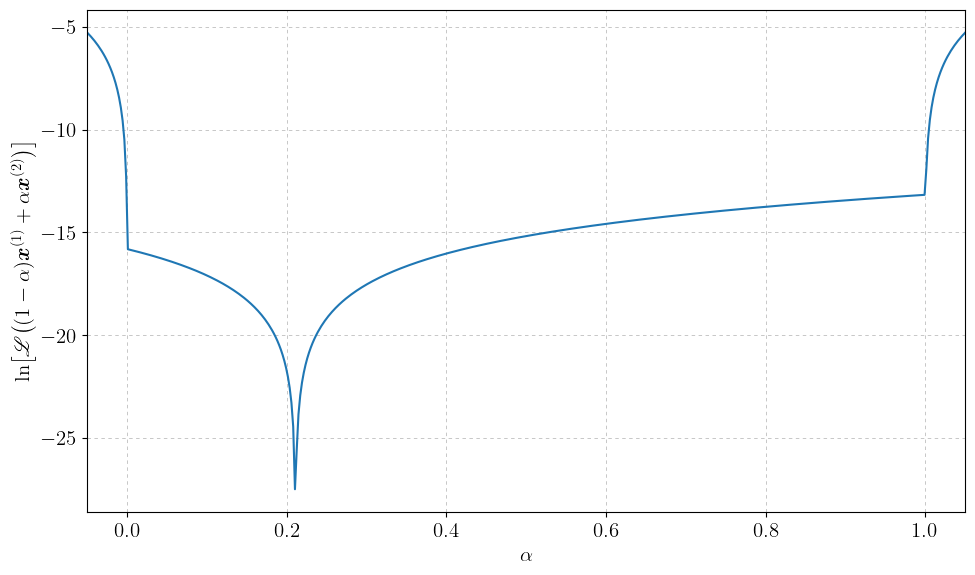

In [ ]:
from importlib import reload

import matplotlib.pyplot as plt
import numpy as np

import FewShotCVRP.bo.bo_pure as bo_pure
import FewShotCVRP.bo.kpcabo as kpcabo

reload(kpcabo)
reload(myplots)

myplots.good_plt_config()


def plot_f_alpha(f, n_points=500, pad=0.05, pad_units="fraction", ax=None, **plot_kwargs):

    # Compute padding on x-axis
    pad_abs = (pad if pad_units == "abs" else pad * 1.0)

    # Grid over [0, 1]
    alpha = np.linspace(-pad_abs, 1.0 + pad_abs, int(n_points))

    # Evaluate f safely (works whether f is vectorized or scalar-only)
    try:
        vals = f(alpha)
    except Exception:
        vals = np.vectorize(f)(alpha)

    # Prepare axis
    created = False
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 6))
        created = True

    ax.set_xlim(-pad_abs, 1.0 + pad_abs)  # extend beyond [0, 1]

    # Plot
    ax.plot(alpha, vals, **plot_kwargs)

    ax.set_xlabel(r"$\alpha$")
    ax.set_ylabel(r"$\ln\!\cl{\mathscr{L}\!\br{(1-\alpha)\bm{x}\unum{1} + \alpha\bm{x}\unum{2}}}$")

    if created:
        plt.tight_layout()
        plt.show()

    return ax


def plotting_callback(obj, res):
    print(res)
    fig, ax = myplots.plot_3D_surface(
        (-0.5, 1.2),
        (-0.5, 1.2),
        lambda x: np.log(obj(x)),
        np.array([res.xbest]),
        is_axis_names=True,
        is_white_facecolor=True,
        is_colorbar=True,
        discretization=100,
        zfactor=2.0,
        is_inverse=True,
    )
    ax.set_xlabel(r"$w_1$", labelpad=10)
    ax.set_ylabel(r"$w_2$", labelpad=10)
    ax.set_zlabel(
        r"$\text{\textbf{(inversed)}}$ " + r"$\ln\!\cl{\mathscr{L}\!\br{\bm{w}}}$",
        labelpad=10,
    )
    plot_f_alpha(lambda alpha: np.log(obj(np.array([1-alpha, alpha]))))


zz = [-0.005]
zz_obj_approx = gp.predict(bo_pure._to_2d(zz), return_std=False)
print(zz_obj_approx)

mapper = kpcabo.KernelPCAMapper(
    bounds=bo.bounds, eta=0.66, pad_frac=0.1, random_state=1
)
mapper.fit(bo.X_, bo.y_)
x_new = mapper.preimage(
    zz,
    zz_obj_approx[0],
    max_anchors=2,
    max_transforms=5000,
    plotting_callback=plotting_callback,
    opt_strategy="convex comb",
)
# print(x_new, f(x_new))

[-951.03626308]


/data/antonovk/venv-cvrp/lib/python3.10/site-packages/cma/utilities/utils.py:362: UserWarning: 
        geno-pheno transformation introduced based on the
        current covariance matrix with condition 1.4e+12 -> 1.0e+00,
        injected solutions become "invalid" in this iteration (time=Sep 10 16:23:56 2025 class=CMAEvolutionStrategy method=alleviate_conditioning iteration=124)
  warnings.warn(msg + ' (time={}'.format(time.asctime()[4:]) +
/data/antonovk/venv-cvrp/lib/python3.10/site-packages/cma/utilities/utils.py:362: UserWarning: 
        geno-pheno transformation introduced based on the
        current covariance matrix with condition 1.3e+12 -> 1.0e+00,
        injected solutions become "invalid" in this iteration (time=Sep 10 16:23:56 2025 class=CMAEvolutionStrategy method=alleviate_conditioning iteration=137)
  warnings.warn(msg + ' (time={}'.format(time.asctime()[4:]) +


CMAEvolutionStrategyResult(xbest=array([0.11588253, 0.16749291, 0.71662456]), fbest=-69.72681424724547, evals_best=1538, evaluations=1666, iterations=238, xfavorite=array([0.11588254, 0.16749291, 0.71662455]), stds=array([3.88195648e-09, 4.82188075e-09, 3.68931481e-10]), stop={'noeffectaxis': None})
5.224314722024468e-31


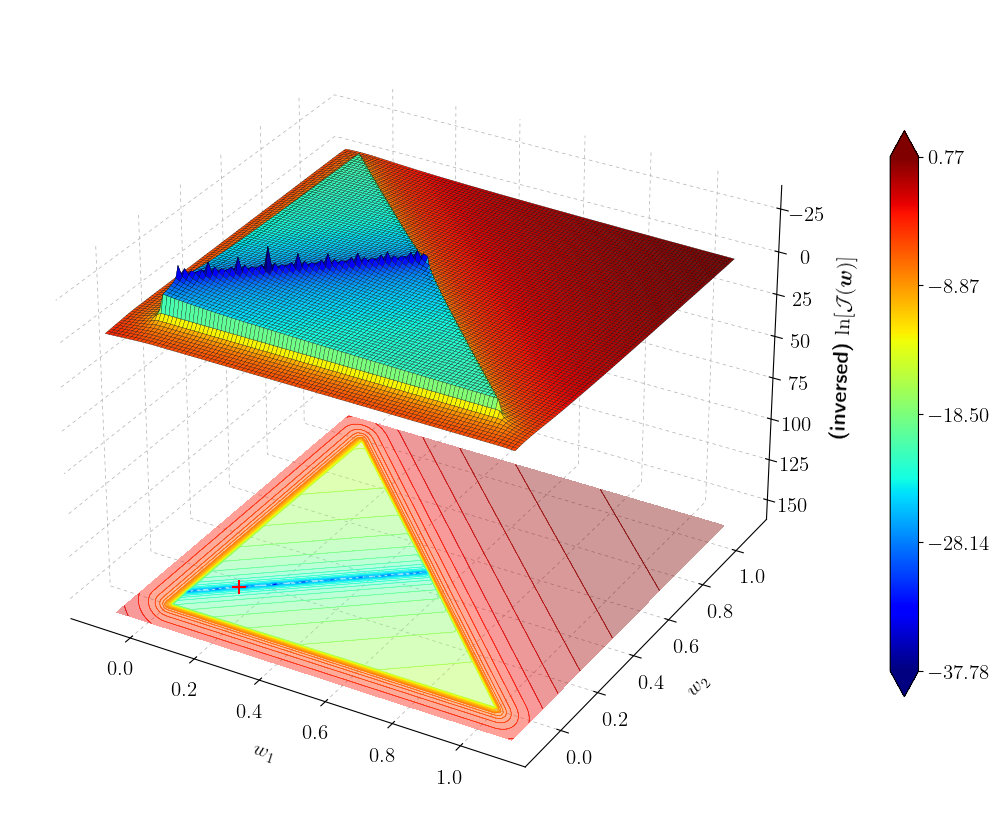

In [ ]:
from importlib import reload

import matplotlib.pyplot as plt
import numpy as np

import FewShotCVRP.bo.bo_pure as bo_pure
import FewShotCVRP.bo.kpcabo as kpcabo

reload(kpcabo)
reload(myplots)


def plotting_callback(obj, res):
    print(res)
    print(obj(res.xbest))
    fig, ax = myplots.plot_3D_surface(
        (-0.1, 1.1),
        (-0.1, 1.1),
        lambda alpha: np.log(obj(np.hstack([alpha, 1.0 - sum(alpha)]))),
        np.array([res.xbest[:2]]),
        is_axis_names=True,
        is_white_facecolor=True,
        is_colorbar=True,
        discretization=100,
        zfactor=2.0,
        is_inverse=True,
    )
    ax.set_xlabel(r"$w_1$", labelpad=10)
    ax.set_ylabel(r"$w_2$", labelpad=10)
    ax.set_zlabel(
        r"$\text{\textbf{(inversed)}}$ " + r"$\ln\!\cl{\mathcal{J}\!\br{\bm{w}}}$",
        labelpad=10,
    )


zz = [0.0]
zz_obj_approx = gp.predict(bo_pure._to_2d(zz), return_std=False)
print(zz_obj_approx)

mapper = kpcabo.KernelPCAMapper(
    bounds=bo.bounds, eta=0.66, pad_frac=0.1, n_restarts_preimage_opt=5, random_state=1
)
mapper.fit(bo.X_, bo.y_)
x_new = mapper.preimage(
    zz,
    zz_obj_approx[0],
    max_anchors=3,
    max_transforms=5000,
    plotting_callback=plotting_callback,
    opt_strategy="convex comb",
)
# print(x_new, f(x_new))

In [40]:
lower = np.array([-1.,-1.,-1.])
upper = np.array([1.,1.,1.])
np.array(list(zip(lower, upper)))

array([[-1.,  1.],
       [-1.,  1.],
       [-1.,  1.]])

In [27]:
np.array([1,2,3])[:2]

array([1, 2])

In [ ]:
np.hstack([np.array([1,2]), 3])

array([1, 2, 3])

In [18]:
print(x_new, f(x_new))

[0.4127721  4.99999459] -926.0148061796351


0.0002300768694373209
0.00028055090316300284
0.00022466583096093115
0.00027609907083871903
0.0002139310746868255
0.00026806683192579184
0.0002102741410169677
0.0002647686968291748
0.00020663060447522196
0.0002614787118463619
0.00020300057020908915
0.0002581968552524726
0.0001993841475264964
0.0002549231049399246
0.00019578145003345713
0.0002516574379249911
0.00019038142720519238
0.0002471603942151397
0.0001868039423792071
0.00024390552256559143
0.00018141308084177924
0.00023939777759269629
0.00017230226461272555
0.00023228680001292066
0.00016875723033203023
0.00022903188960148927
0.00016334505366211416
0.00022445975976084984
0.00015602150387786785
0.000218512988231265
0.00015058956183668307
0.0002138829895244641
0.0001470947793690414
0.00021062929055802801
0.00013775128022272738
0.00020312248642760945
0.00012422698587234574
0.00019240876711655063
0.00011870746494301176
0.00018755355761881462
0.0001111017650244217
0.00018106686114000223
0.00010344939516430757
0.00017446123403508886
9.78

/data/antonovk/venv-cvrp/lib/python3.10/site-packages/cma/utilities/utils.py:362: UserWarning: sigma change np.exp(1.117757950596896) = 3.057990346184536 clipped to np.exp(+-1) (time=Sep 10 11:40:24 2025 class=CMAAdaptSigmaCSA method=update iteration=48)
  warnings.warn(msg + ' (time={}'.format(time.asctime()[4:]) +
/data/antonovk/venv-cvrp/lib/python3.10/site-packages/cma/utilities/utils.py:362: UserWarning: sigma change np.exp(1.1714775654277918) = 3.2267568623192 clipped to np.exp(+-1) (time=Sep 10 11:40:25 2025 class=CMAAdaptSigmaCSA method=update iteration=48)
  warnings.warn(msg + ' (time={}'.format(time.asctime()[4:]) +
/data/antonovk/venv-cvrp/lib/python3.10/site-packages/cma/utilities/utils.py:362: UserWarning: sigma change np.exp(1.1435596170475837) = 3.137918296131576 clipped to np.exp(+-1) (time=Sep 10 11:40:27 2025 class=CMAAdaptSigmaCSA method=update iteration=48)
  warnings.warn(msg + ' (time={}'.format(time.asctime()[4:]) +
/data/antonovk/venv-cvrp/lib/python3.10/site-p

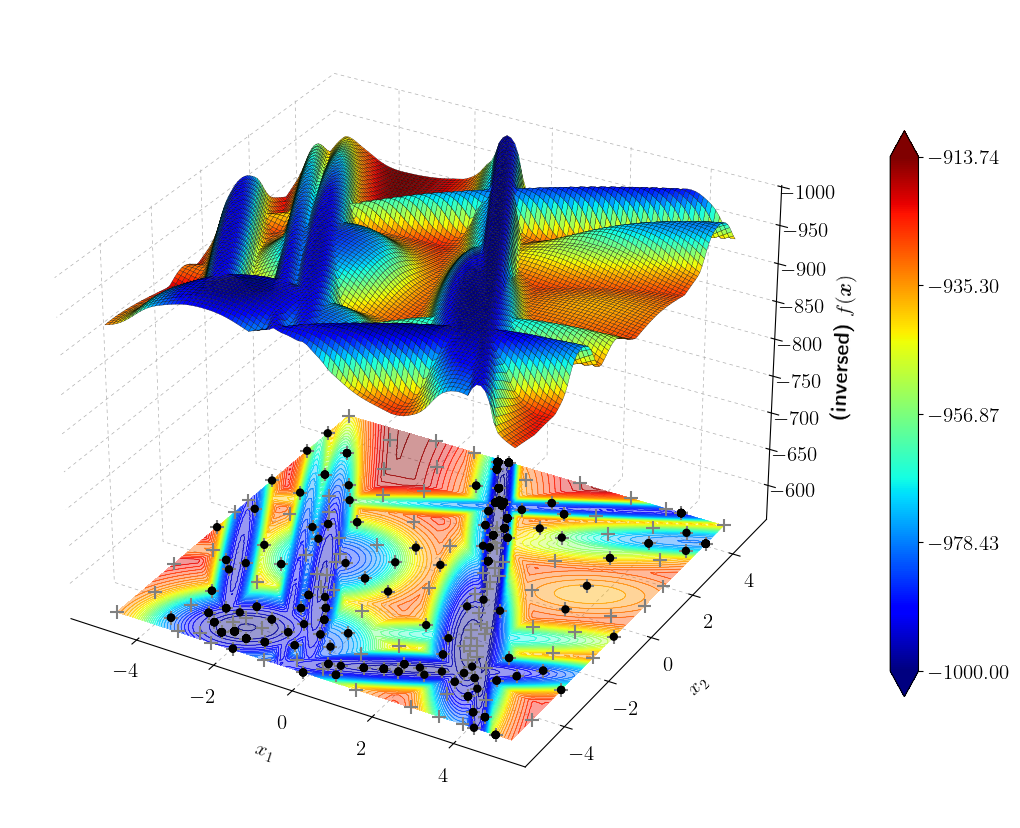

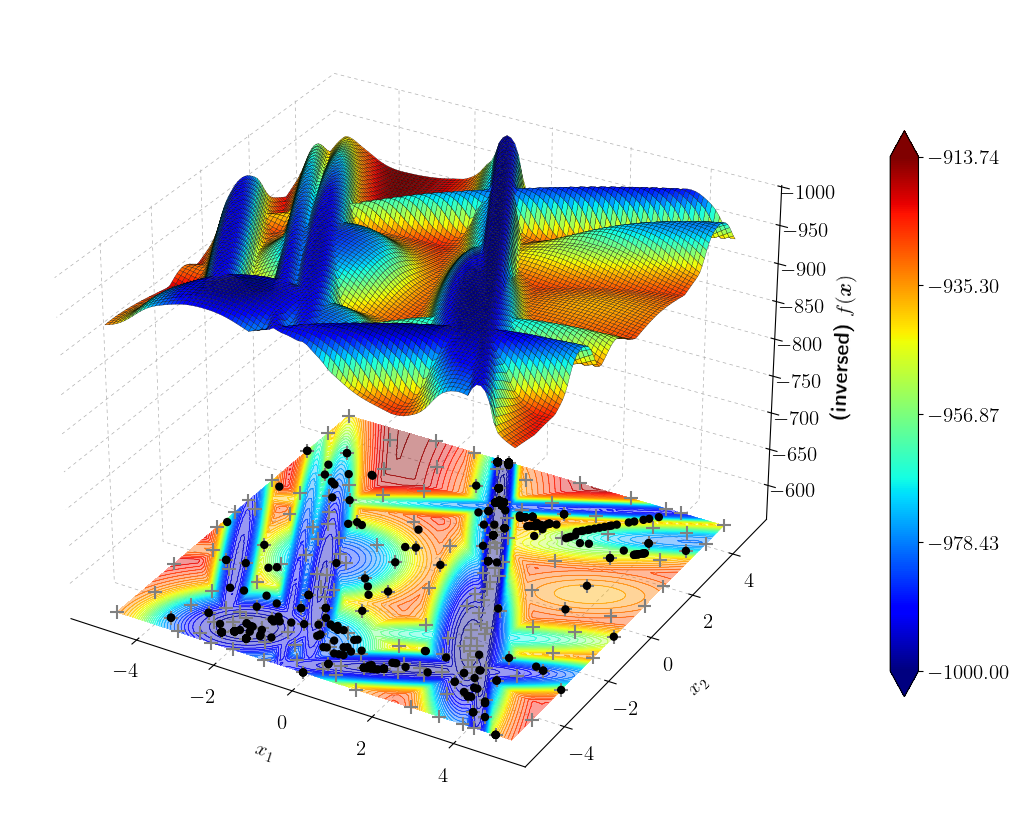

In [23]:
reload(kpcabo)

x = np.asarray(x).ravel()
ptp = np.ptp(x) if x.size > 1 else 1.0
margin = 0.05 * ptp
x_min, x_max = x.min() - margin, x.max() + margin
X_grid = np.linspace(x_min, x_max, 500)
mapper = kpcabo.KernelPCAMapper(
    bounds=bo.bounds, eta=0.66, pad_frac=0.1, random_state=1
)
mapper.fit(bo.X_, bo.y_)

for strategy in ["linear comb", "convex comb"]:
    X_manifold = []
    for x_grid_i in X_grid:
        zz = [x_grid_i]
        zz_obj_approx = gp.predict(bo_pure._to_2d(zz), return_std=False)
        x_new = mapper.preimage(
            zz,
            zz_obj_approx[0],
            max_anchors=2,
            max_transforms=5000,
            opt_strategy=strategy,
            # plotting_callback=plotting_callback,
        )
        X_manifold.append(x_new)
        
    X_manifold = np.array(X_manifold)

    fig, ax = myplots.plot_3D_surface(
        (-5, 5),
        (-5, 5),
        f,
        bo.X_,
        is_axis_names=True,
        is_white_facecolor=True,
        is_colorbar=True,
        discretization=100,
        zfactor=2.0,
        is_inverse=True,
        scatter_search_space_color="grey"
    )
    zax_min, zax_max = ax.get_zlim()

    ax.scatter(
        X_manifold[:, 0],
        X_manifold[:, 1],
        zax_min,
        c="black",
        marker=".",
        s=100,
        alpha=1,
        zorder=5,
    )

/data/antonovk/venv-cvrp/lib/python3.10/site-packages/cma/utilities/utils.py:362: UserWarning: 
        geno-pheno transformation introduced based on the
        current covariance matrix with condition 1.0e+12 -> 1.0e+00,
        injected solutions become "invalid" in this iteration (time=Sep 10 16:27:15 2025 class=CMAEvolutionStrategy method=alleviate_conditioning iteration=142)
  warnings.warn(msg + ' (time={}'.format(time.asctime()[4:]) +
/data/antonovk/venv-cvrp/lib/python3.10/site-packages/cma/utilities/utils.py:362: UserWarning: 
        geno-pheno transformation introduced based on the
        current covariance matrix with condition 1.2e+12 -> 1.0e+00,
        injected solutions become "invalid" in this iteration (time=Sep 10 16:27:16 2025 class=CMAEvolutionStrategy method=alleviate_conditioning iteration=144)
  warnings.warn(msg + ' (time={}'.format(time.asctime()[4:]) +
/data/antonovk/venv-cvrp/lib/python3.10/site-packages/cma/utilities/utils.py:362: UserWarning: 
        ge

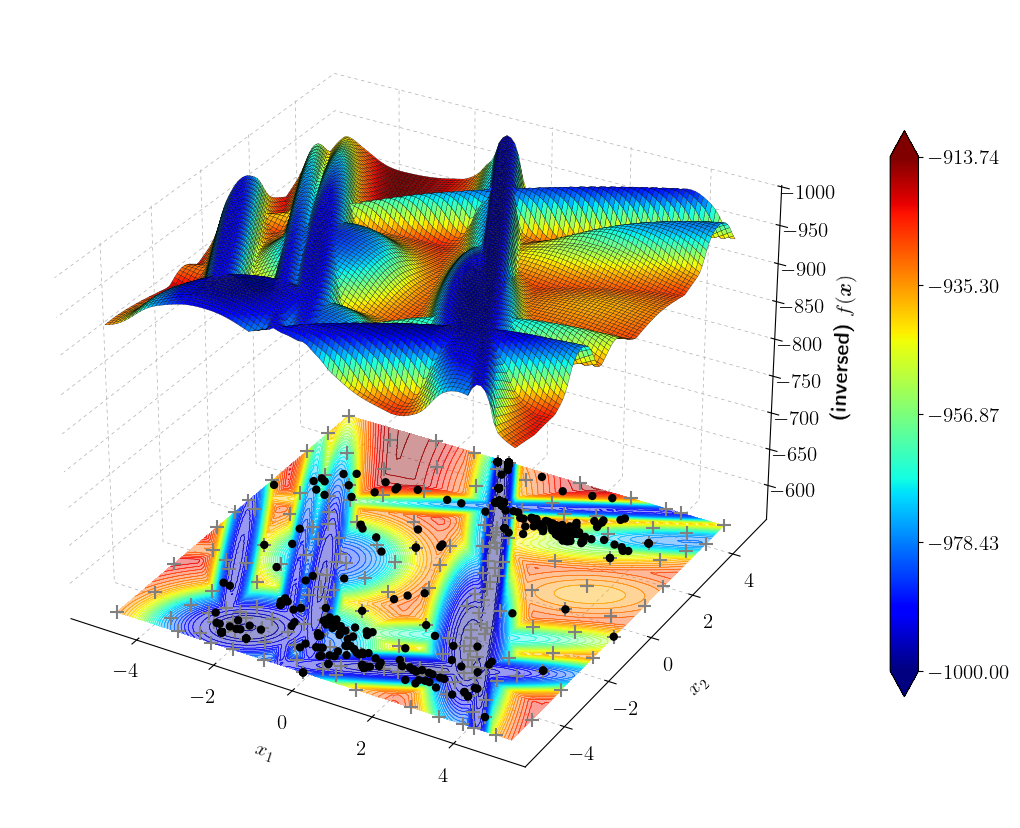

In [81]:
reload(kpcabo)

x = np.asarray(x).ravel()
ptp = np.ptp(x) if x.size > 1 else 1.0
margin = 0.05 * ptp
x_min, x_max = x.min() - margin, x.max() + margin
X_grid = np.linspace(x_min, x_max, 500)
mapper = kpcabo.KernelPCAMapper(
    bounds=bo.bounds, eta=0.66, pad_frac=0.1, random_state=1
)
mapper.fit(bo.X_, bo.y_)

for strategy in ["convex comb"]:
    X_manifold = []
    for x_grid_i in X_grid:
        zz = [x_grid_i]
        zz_obj_approx = gp.predict(bo_pure._to_2d(zz), return_std=False)
        x_new = mapper.preimage(
            zz,
            zz_obj_approx[0],
            max_anchors=3,
            max_transforms=5000,
            opt_strategy=strategy,
            # plotting_callback=plotting_callback,
        )
        X_manifold.append(x_new)
        
    X_manifold = np.array(X_manifold)

    fig, ax = myplots.plot_3D_surface(
        (-5, 5),
        (-5, 5),
        f,
        bo.X_,
        is_axis_names=True,
        is_white_facecolor=True,
        is_colorbar=True,
        discretization=100,
        zfactor=2.0,
        is_inverse=True,
        scatter_search_space_color="grey"
    )
    zax_min, zax_max = ax.get_zlim()

    ax.scatter(
        X_manifold[:, 0],
        X_manifold[:, 1],
        zax_min,
        c="black",
        marker=".",
        s=100,
        alpha=1,
        zorder=5,
    )

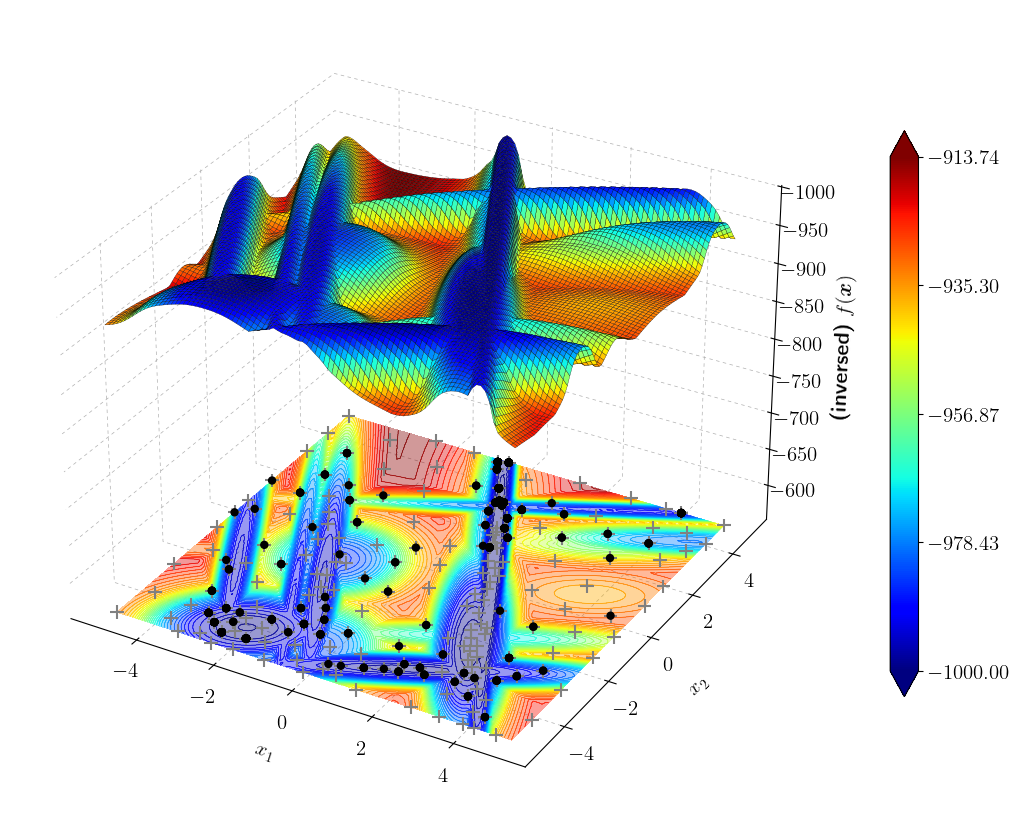

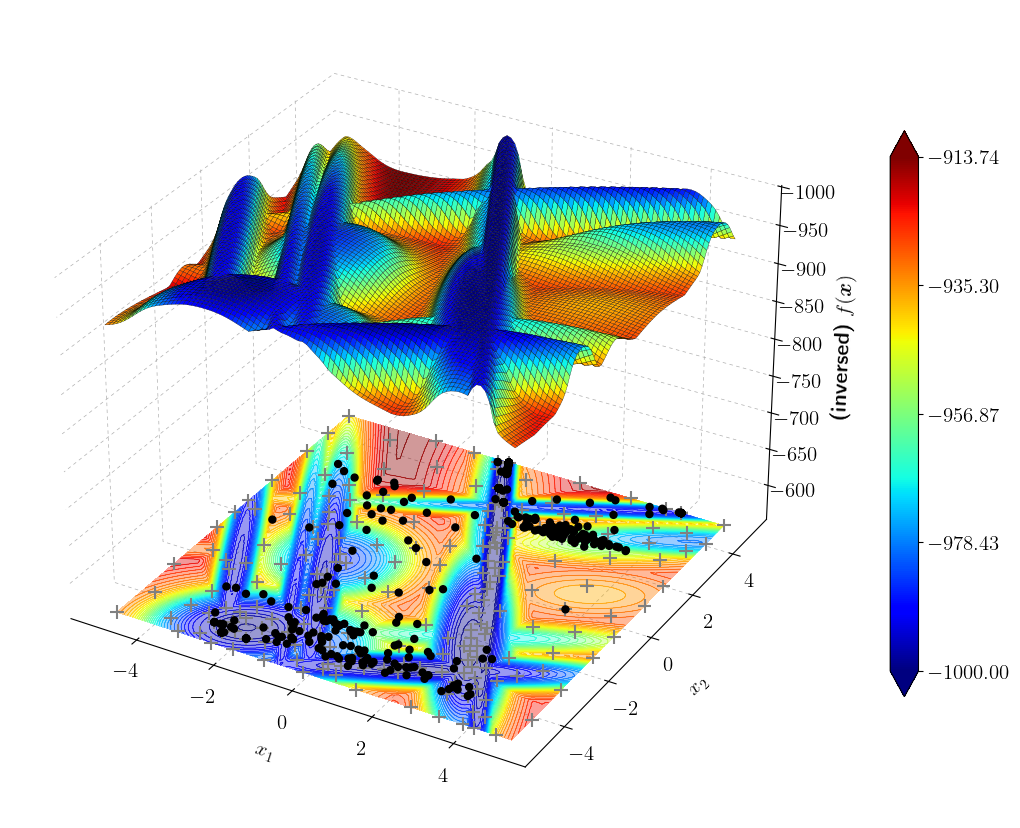

In [24]:
reload(kpcabo)

x = np.asarray(x).ravel()
ptp = np.ptp(x) if x.size > 1 else 1.0
margin = 0.05 * ptp
x_min, x_max = x.min() - margin, x.max() + margin
X_grid = np.linspace(x_min, x_max, 500)
mapper = kpcabo.KernelPCAMapper(
    bounds=bo.bounds, eta=0.66, pad_frac=0.1, random_state=1
)
mapper.fit(bo.X_, bo.y_)

for strategy in ["linear comb", "convex comb"]:
    X_manifold = []
    for x_grid_i in X_grid:
        zz = [x_grid_i]
        zz_obj_approx = gp.predict(bo_pure._to_2d(zz), return_std=False)
        x_new = mapper.preimage(
            zz,
            zz_obj_approx[0],
            max_anchors=5,
            max_transforms=5000,
            opt_strategy=strategy,
            # plotting_callback=plotting_callback,
        )
        X_manifold.append(x_new)
        
    X_manifold = np.array(X_manifold)

    fig, ax = myplots.plot_3D_surface(
        (-5, 5),
        (-5, 5),
        f,
        bo.X_,
        is_axis_names=True,
        is_white_facecolor=True,
        is_colorbar=True,
        discretization=100,
        zfactor=2.0,
        is_inverse=True,
        scatter_search_space_color="grey"
    )
    zax_min, zax_max = ax.get_zlim()

    ax.scatter(
        X_manifold[:, 0],
        X_manifold[:, 1],
        zax_min,
        c="black",
        marker=".",
        s=100,
        alpha=1,
        zorder=5,
    )

In [29]:
X_manifold

array([[ 0.02480291,  3.38005909],
       [ 0.02481322,  3.38008068],
       [ 0.02484116,  3.38013922],
       [ 0.02484463,  3.38014648],
       [ 0.02484799,  3.38015352],
       [ 0.0248508 ,  3.38015942],
       [ 0.02485403,  3.38016619],
       [ 0.02485704,  3.38017248],
       [ 0.02486545,  3.3801901 ],
       [ 0.02486838,  3.38019625],
       [ 0.02487656,  3.38021339],
       [ 0.02489542,  3.38025288],
       [ 0.02489802,  3.38025833],
       [ 0.02490474,  3.38027242],
       [ 0.02491674,  3.38029756],
       [ 0.02492287,  3.38031039],
       [ 0.02492409,  3.38031296],
       [ 0.02493843,  3.38034299],
       [ 0.02495931,  3.38038675],
       [ 0.02496273,  3.3803939 ],
       [ 0.02496797,  3.38040488],
       [ 0.02497218,  3.38041371],
       [ 0.0249722 ,  3.38041374],
       [ 0.024971  ,  3.38041122],
       [ 0.02496873,  3.38040647],
       [ 0.02496462,  3.38039786],
       [ 0.02495977,  3.38038771],
       [ 0.02495497,  3.38037764],
       [ 0.0249492 ,

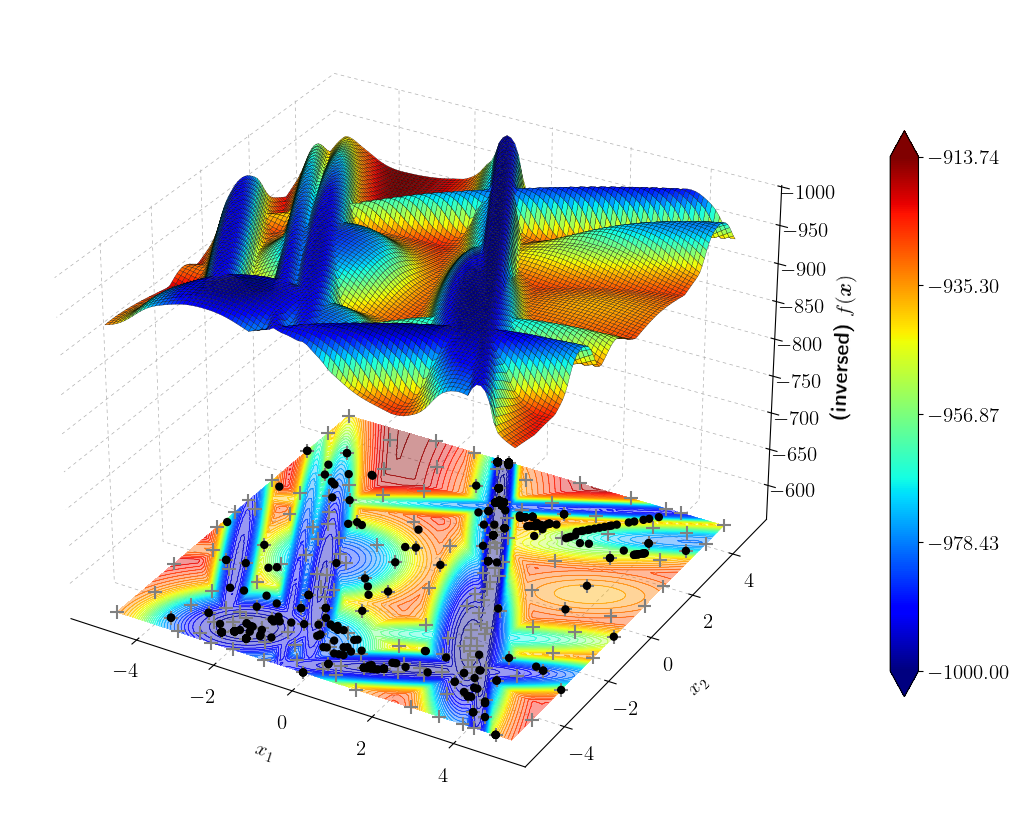

In [19]:
idx = np.array([121,202,69,109,184,133,101,174,123,106])

fig, ax = myplots.plot_3D_surface(
    (-5, 5),
    (-5, 5),
    f,
    bo.X_,
    is_axis_names=True,
    is_white_facecolor=True,
    is_colorbar=True,
    discretization=100,
    zfactor=2.0,
    is_inverse=True,
    scatter_search_space_color="grey"
)
zax_min, zax_max = ax.get_zlim()
# ax.scatter(
#     bo.X_[idx, 0],
#     bo.X_[idx, 1],
#     zax_min,
#     c="red",
#     marker="+",
#     s=100,
#     alpha=1,
#     zorder=4,
# )
ax.scatter(
    X_manifold[:, 0],
    X_manifold[:, 1],
    zax_min,
    c="black",
    marker=".",
    s=100,
    alpha=1,
    zorder=5,
)

New dimensionality 1


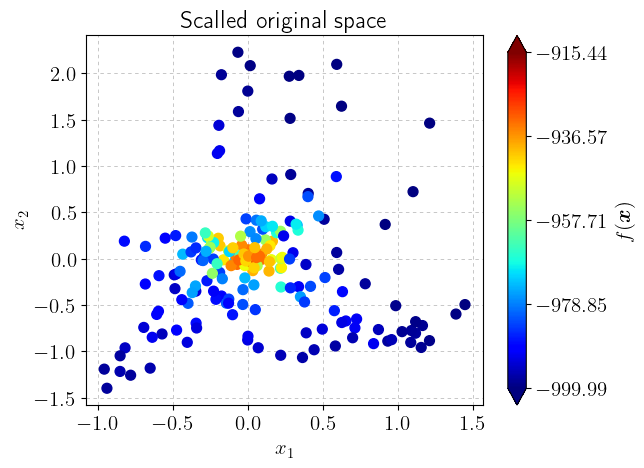

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import FewShotCVRP.bo.kpcabo as kpcabo

from importlib import reload

reload(kpcabo)

mapper = kpcabo.KernelPCAMapper(bounds=bo.bounds, eta=0.66, pad_frac=0.1, random_state=1)
mapper.fit(bo.X_, bo.y_)
Z = mapper.transform(bo.X_, bo.y_)
print(f"New dimensionality {Z.shape[1]}")

# Пример данных: замените на свои реальные массивы
# X — двумерный массив формы (n_samples, 2)
# y — одномерный массив длины n_samples
# Здесь просто для иллюстрации:
X = mapper.Xc
y = bo.y_

# Создаем фигуру и ось
fig, ax = plt.subplots()

# Рисуем scatter-график:
# - X[:,0] — координаты по X, X[:,1] — по Y
# - c=y — цветовая кодировка по y
# - cmap='jet' — используем colormap "jet"
# - s=50 — размер маркеров (опционально)
scatter = ax.scatter(X[:, 0], X[:, 1], c=y, cmap="jet", s=50, zorder=2)


# Подписи осей (опционально)
ax.set_xlabel(r"$x_1$")
ax.set_ylabel(r"$x_2$")
ax.set_title("Scalled original space")

fig.colorbar(
    scatter,
    ax=ax,
    # shrink=0.7,
    ticks=np.linspace(y.min(), y.max(), 5),
    orientation="vertical",
    extend="both",
    label=r"$f(\bm{x})$",
)

plt.show()

In [45]:
y = np.array([10, 50, 30])
sorter = np.argsort(y)        # array([0, 2, 1]) -> y_sorted = [10, 30, 50]
idx_sorted = np.array([2])    # pick 50 in the sorted array
idx_original = sorter[idx_sorted]   # -> [1], indeed y[1] == 50


In [46]:
y = np.array([30, 10, 40, 20])
sorter = np.argsort(y) # array([2, 0, 3, 1]) -> y_sorted = [10, 20, 30, 40] 
idx_sorted = np.array([1]) # pick 20 in the sorted array 
idx_original = sorter[idx_sorted] # -> [0], but y[0] == 30, which is NOT 20

print(sorter)

[1 3 0 2]


In [47]:
y[sorter]

array([10, 20, 30, 40])

In [51]:
np.atleast_1d(10.0, float)

(array([10.]), array([<class 'float'>], dtype=object))